# SVM

In [2]:
import pandas as pd
from huggingface_hub.keras_mixin import keras
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

data = pd.read_excel('tech.xlsx')
def map_score_to_category(score):
    if score < 0:
        return -1
    else:
        return 1

data['emotion_category'] = data['score'].apply(map_score_to_category)

# 分割数据为训练集和测试集
X = data['title']
y = data['emotion_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用TF-IDF特征提取
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 创建SVM模型
svm_model = SVC(kernel='linear', C=1.0)

# 训练模型
svm_model.fit(X_train_tfidf, y_train)

# 预测情感类别
y_pred = svm_model.predict(X_test_tfidf)

# 输出评估指标
print(classification_report(y_test, y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.00      0.01       237
           1       0.86      1.00      0.93      1476

    accuracy                           0.86      1713
   macro avg       0.68      0.50      0.47      1713
weighted avg       0.81      0.86      0.80      1713

Accuracy: 0.861646234676007


# LSTM

Epoch 1/50
215/215 - 3s - 12ms/step - loss: 0.3593 - val_loss: 0.1532
Epoch 2/50
215/215 - 1s - 4ms/step - loss: 0.1628 - val_loss: 0.1524
Epoch 3/50
215/215 - 1s - 4ms/step - loss: 0.1551 - val_loss: 0.1616
Epoch 4/50
215/215 - 1s - 4ms/step - loss: 0.1093 - val_loss: 0.1764
Epoch 5/50
215/215 - 1s - 4ms/step - loss: 0.0705 - val_loss: 0.1701
Epoch 6/50
215/215 - 1s - 4ms/step - loss: 0.0581 - val_loss: 0.1705
Epoch 7/50
215/215 - 1s - 4ms/step - loss: 0.0527 - val_loss: 0.1708
Epoch 8/50
215/215 - 1s - 4ms/step - loss: 0.0492 - val_loss: 0.1734
Epoch 9/50
215/215 - 1s - 4ms/step - loss: 0.0471 - val_loss: 0.1741
Epoch 10/50
215/215 - 1s - 4ms/step - loss: 0.0457 - val_loss: 0.1747
Epoch 11/50
215/215 - 1s - 4ms/step - loss: 0.0447 - val_loss: 0.1747
Epoch 12/50
215/215 - 1s - 4ms/step - loss: 0.0440 - val_loss: 0.1786
Epoch 13/50
215/215 - 1s - 4ms/step - loss: 0.0433 - val_loss: 0.1764
Epoch 14/50
215/215 - 1s - 4ms/step - loss: 0.0427 - val_loss: 0.1764
Epoch 15/50
215/215 - 1s - 4

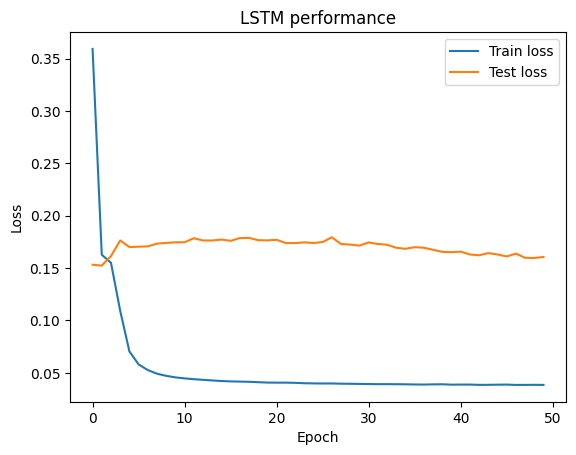

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle
import importlib
importlib.invalidate_caches()
from keras import regularizers

df = pd.read_excel('tech.xlsx')

# 数据随机打乱
data = shuffle(df)

# 构建词汇表，将标题文本转换为数字序列
tokenizer = tf.keras.layers.TextVectorization(output_mode='int')
tokenizer.adapt(data['title'])

# 将标题文本转换为数字序列
title_sequences = tokenizer(data['title']).numpy()

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(title_sequences, np.array(data['score']), test_size=0.2, random_state=42)

# 构建模型
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.LSTM(64,kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 编译模型
model.compile(optimizer, loss='mean_squared_error')

# 记录损失
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.title('LSTM performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ALL LSTM

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras import regularizers
from keras._tf_keras.keras.layers import Layer, Embedding, LSTM, Dense, Input, TextVectorization

data = pd.read_excel('tech.xlsx')
scores = data['score']
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], input_shape[-1]), initializer="uniform")
        self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], input_shape[-1]), initializer="uniform")
        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        q = tf.matmul(x, self.W_q)
        k = tf.matmul(x, self.W_k)
        v = x

        attention_weights = tf.nn.softmax(tf.matmul(q, k, transpose_b=True), axis=-1)
        output = tf.matmul(attention_weights, v)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape
# 定义新闻标题数据和对应的分数数据
# df = pd.read_excel('tech.xlsx') # /content/drive/MyDrive/数据集/数据集/大豆/gpt_soybean20180709-20180927.xlsx
# data = shuffle(df)
#mean_score = data['score'].mean()
#data['score'].fillna(mean_score, inplace=True)
# def map_score_to_category(score):
#     if score <= 0:
#         return 0
#     else:
#         return 1
# data['emotion_category'] = data['score'].apply(map_score_to_category)
# scores = data['emotion_category']

# 构建词汇表，将标题文本转换为数字序列
tokenizer = TextVectorization(output_mode='int')
tokenizer.adapt(data['title'])

# 将标题文本转换为数字序列
title_sequences = tokenizer(data['title']).numpy()

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(title_sequences, np.array(scores), test_size=0.3, random_state=42)


# 构建模型
input_layer = Input(shape=(title_sequences.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.get_vocabulary()), output_dim=64, mask_zero=True)(input_layer)
lstm_layer = LSTM(64, kernel_regularizer=regularizers.l2(0.01),return_sequences=True)(embedding_layer)
attention_layer = AttentionLayer()(lstm_layer)
output_layer = Dense(1)(attention_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
# 定义精度指标函数
def custom_accuracy(y_true, y_pred):
    threshold = 0.4  # 自定义阈值 0.5 0.1 0.3
    absolute_error = tf.abs(y_true - y_pred)
    correct_predictions = tf.reduce_mean(tf.cast(absolute_error < threshold, tf.float32))
    return correct_predictions

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[custom_accuracy])

# 训练模型
#model.fit(X_train, y_train, epochs=100, verbose=2)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)
train_loss = history.history['loss']
test_loss = history.history['val_loss']
accuracy = history.history['custom_accuracy']  # 获取精度值

Epoch 1/50


D:\anaconda3\envs\ml_pro\lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


188/188 - 3s - 17ms/step - custom_accuracy: 0.6673 - loss: 0.3995 - val_custom_accuracy: 0.7793 - val_loss: 0.1638
Epoch 2/50
188/188 - 1s - 6ms/step - custom_accuracy: 0.7769 - loss: 0.1623 - val_custom_accuracy: 0.7793 - val_loss: 0.1605
Epoch 3/50
188/188 - 1s - 5ms/step - custom_accuracy: 0.7770 - loss: 0.1618 - val_custom_accuracy: 0.7793 - val_loss: 0.1607
Epoch 4/50
188/188 - 1s - 5ms/step - custom_accuracy: 0.7770 - loss: 0.1617 - val_custom_accuracy: 0.7793 - val_loss: 0.1607
Epoch 5/50
188/188 - 1s - 5ms/step - custom_accuracy: 0.7774 - loss: 0.1618 - val_custom_accuracy: 0.7793 - val_loss: 0.1605
Epoch 6/50
188/188 - 1s - 6ms/step - custom_accuracy: 0.7770 - loss: 0.1619 - val_custom_accuracy: 0.7793 - val_loss: 0.1605
Epoch 7/50
188/188 - 1s - 6ms/step - custom_accuracy: 0.7774 - loss: 0.1617 - val_custom_accuracy: 0.7793 - val_loss: 0.1605
Epoch 8/50
188/188 - 1s - 6ms/step - custom_accuracy: 0.7774 - loss: 0.1619 - val_custom_accuracy: 0.7793 - val_loss: 0.1605
Epoch 9/50

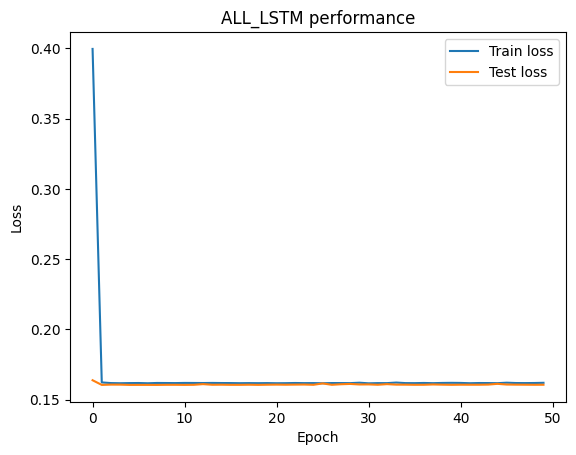

In [5]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.title('ALL_LSTM performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# seq2seq

In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras._tf_keras.keras.preprocessing.text import Tokenizer
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.layers import Layer, Embedding, LSTM, Dense, Input, TextVectorization
# 数据读取
data = pd.read_excel('tech.xlsx')
title = data['title']
score = data['score']

# 文本标记化
tokenizer = TextVectorization(output_mode='int')
tokenizer.adapt(data['title'])

# 将标题文本转换为数字序列
title_sequences = tokenizer(data['title']).numpy()

X_train, X_test, y_train, y_test = train_test_split(title_sequences, score, test_size=0.3, random_state=42)

# 编码器




array([[6216,    0,    0,    0],
       [5705,    0,    0,    0],
       [7026,    0,    0,    0],
       ...,
       [7793,    0,    0,    0],
       [1894, 1387,    0,    0],
       [5904,    0,    0,    0]], dtype=int64)

# Transformer

In [7]:
import numpy as np
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.text import Tokenizer
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 数据读取
data = pd.read_excel('tech.xlsx')
title = data['title']
score = data['score']

# 文本标记化
tokenizer = Tokenizer()
tokenizer.fit_on_texts(title)
sequences = tokenizer.texts_to_sequences(title)

# 序列填充
max_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
labels = np.array(score)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 32
num_heads = 2
dff = 32
num_encoder_layers = 2 

# 位置编码
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# 建立Transformer模型
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.multi_head_attention(inputs, inputs, return_attention_scores=False)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=True):
        seq_len = tf.shape(inputs)[1]
        inputs = self.embedding(inputs)
        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        inputs += self.pos_encoding[:, :seq_len, :]
        inputs = self.dropout(inputs, training=training)
        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training)
        return inputs

# 构建Transformer模型
class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(TransformerModel, self).__init__()
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1, activation='linear')

    def call(self, inputs, training=True):
        enc_output = self.encoder(inputs, training)
        flattened_output = self.flatten(enc_output)
        output = self.dense(flattened_output)
        return output


# 初始化并训练模型
model = TransformerModel(
    num_layers=num_encoder_layers,
    d_model=embedding_dim,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    maximum_position_encoding=max_len,
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))
train_loss = history.history['loss']
test_loss = history.history['val_loss']
loss, mae = model.evaluate(X_test, y_test)

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title('Transformer performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50


ValueError: Exception encountered when calling TransformerModel.call().

[1mOnly input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: True (of type <class 'bool'>)[0m

Arguments received by TransformerModel.call():
  • inputs=tf.Tensor(shape=(None, 9), dtype=int32)
  • training=True

In [6]:
import numpy as np
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.text import Tokenizer
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 数据读取
data = pd.read_excel('tech.xlsx')
title = data['title']
score = data['score']

# 文本标记化
tokenizer = Tokenizer()
tokenizer.fit_on_texts(title)
sequences = tokenizer.texts_to_sequences(title)
print(sequences)

[[81, 82], [83, 84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94, 95, 96], [97], [98], [99, 100], [101], [102], [103], [104], [105], [106], [107], [108, 109], [110, 111], [112], [113], [114, 115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126, 127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152, 153], [154], [155], [156], [157], [158, 159], [160, 161], [162], [163], [164], [165], [166], [167], [168], [169], [170, 171], [172, 173], [174], [175, 176], [177], [178, 179], [180], [181, 182], [183], [184, 185], [186], [187], [188, 189], [190], [191], [192, 193], [194], [195], [196], [197], [198], [199, 200], [201], [202], [203], [204, 205, 206], [207], [208], [209], [210], [211], [212], [213, 214], [215, 216], [217, 218], [219], [220], [221], [222], [223], [224, 225], [226, 227], [228], [229], [230], [231], [232], [233], [23

# 朴素贝叶斯

In [5]:
import pandas as pd
import numpy as np
import jieba
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

data = pd.read_excel('tech.xlsx')

def score_to_binary(score):
    if score > 0:
        return 1
    else:
        return 0


data['emotion_binary'] = data['score'].apply(score_to_binary)

#训练集，测试集划分
X = data['title']
y = data['emotion_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用TF-IDF特征提取
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 构建贝叶斯分类器
mb = MultinomialNB(alpha=1)
mb.fit(X_train_tfidf, y_train)

# 预测数据
y_pred = mb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(mb.score(X_test_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.83      0.39      0.53       377
           1       0.85      0.98      0.91      1336

    accuracy                           0.85      1713
   macro avg       0.84      0.68      0.72      1713
weighted avg       0.84      0.85      0.83      1713

0.8476357267950964


# BERT

In [11]:
from transformers import pipeline

classfier = pipeline('sentiment-analysis')

result = classfier("hello i love zhaung pei cheng")
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9996703863143921}]
